In [2]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install imageio


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
SEED = 0
seed_everything(SEED)

D1107 17:10:50.075200948    4938 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1107 17:10:50.075226928    4938 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1107 17:10:50.075230453    4938 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1107 17:10:50.075233329    4938 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1107 17:10:50.075251578    4938 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1107 17:10:50.075254609    4938 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1107 17:10:50.075257117    4938 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1107 17:10:50.

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

Running on TPU 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS: 8


In [6]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

In [7]:
#GCS_PATH = "/kaggle/input/gan-getting-started"#KaggleDatasets().get_gcs_path('gan-getting-started')
#GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
# EXT_PATH = KaggleDatasets().get_gcs_path('tfrecords-monet-paintings-256x256')
# EXT_PATH = KaggleDatasets().get_gcs_path('monet-tfrecords-256x256')

MONET_FILENAMES = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/monet_tfrec/monet*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/photo_tfrec/photo*.tfrec'))
# MONET_FILENAMES = tf.io.gfile.glob(str(EXT_PATH + '/monet*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


In [8]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    
#     # Random jitter
#     image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
#     # Crops
#     if p_crop > .6: # random crop
#         crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
#         image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
#     elif p_crop > .2: # central crop
#         if p_crop > .5:
#             image = tf.image.central_crop(image, central_fraction=.7)
#         elif p_crop > .35:
#             image = tf.image.central_crop(image, central_fraction=.8)
#         else:
#             image = tf.image.central_crop(image, central_fraction=.9)
            
    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
        
    
    return image

In [9]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    
    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        f = plt.figure(figsize=(12, 12))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()
    
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)
        
        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')
        
        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')
        
        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')
        
    plt.show()

def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [10]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = L.ReLU()(block)
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    
    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
#     block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") # Works only with GPU
#     block = L.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, # Works only with GPU
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block


In [11]:
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=True, activation=L.ReLU(), name='block_1') # (bs, 256, 256, 64)
    drop = L.Dropout(0.5)
    # Transformer
    #x_skip = enc_1
    
    x_skip = drop(enc_1)
    
    enc_2 = encoder_block(x_skip, 256,  7, 1, apply_instancenorm=True, activation=L.ReLU(), name='block_2')
    x_skip = drop(enc_2)
    #x_skip = L.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(x_skip)
    dec_1 = decoder_block(x_skip, 256, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    enc_3 = L.MaxPooling2D(pool_size=(1, 1),strides=(1, 1), padding='valid')(dec_1)
    #dec_2 = decoder_block(x_skip, 64, 3, 2, apply_instancenorm=True, name='block_2')
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_3])
    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=2, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)
    #outputs = x_skip
    generator = Model(inputs, outputs)
    
    return generator
    

sample_generator = generator_fn()
sample_generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block_1 (Conv2D)       (None, 256, 256, 64  9408        ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 instance_normalization (Instan  (None, 256, 256, 64  128        ['encoder_block_1[0][0]']        
 ceNormalization)               )                                                             

/usr/local/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [12]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder    
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = decoder_block(x, 512, 3, 2, apply_instancenorm=True, name='disc_block_1')
    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)
    
    discriminator = Model(inputs, outputs)
    
    return discriminator


sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 encoder_block_1 (Conv2D)    (None, 128, 128, 64)      3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 decoder_disc_block_1 (Conv2  (None, 256, 256, 512)    294912    
 DTranspose)                                                     
                                                                 
 instance_normalization_3 (I  (None, 256, 256, 512)    1024      
 nstanceNormalization)                                           
                                                                 
 re_lu_4 (ReLU)              (None, 256, 256, 512)     0   

In [13]:
with strategy.scope():
    monet_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
    photo_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn(height=None, width=None) # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': photo_disc_loss
               }

In [14]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

10 total epochs and 439 steps per epoch
Learning rate schedule: 0.0002 to 0.0002 to 9.12e-06


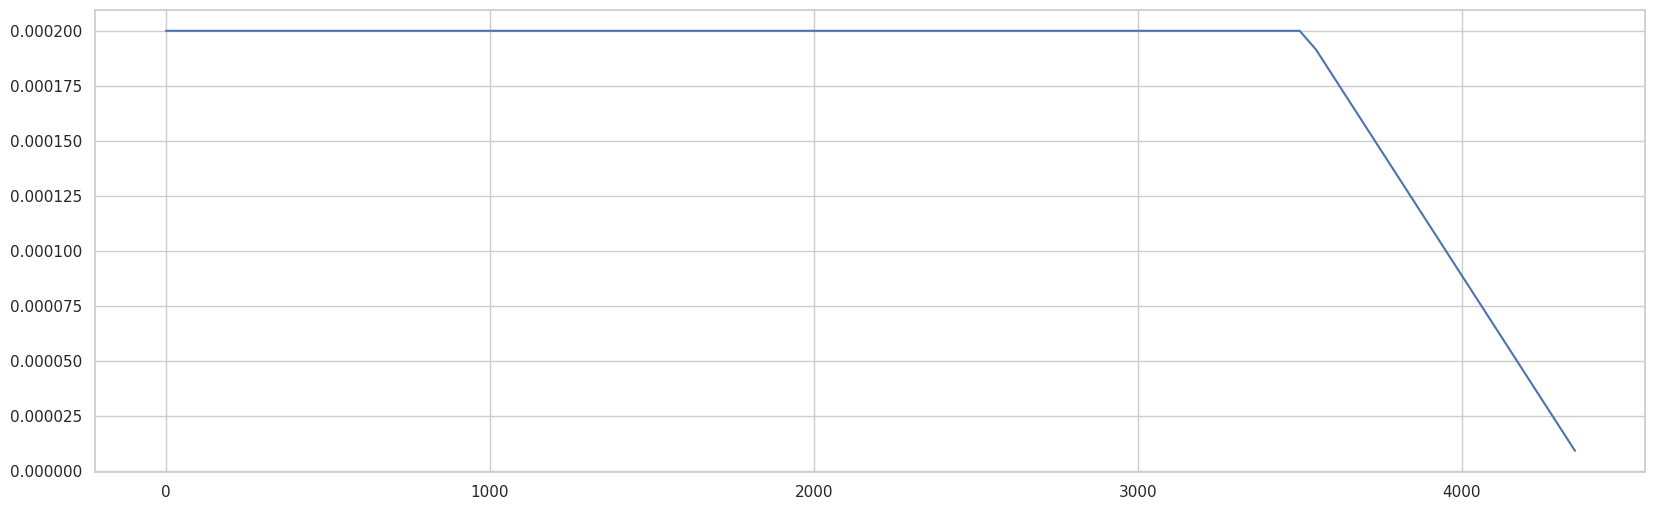

In [15]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(n_monet_samples, n_photo_samples) // BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [16]:
with strategy.scope():
    monet_generator_optimizer = optimizers.Adam(learning_rate=0.7, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(learning_rate=0.7, beta_1=0.5)

    # Create generators
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = optimizers.Adam(learning_rate=0.7, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(learning_rate=0.7, beta_1=0.5)
    # Create discriminators
    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

In [17]:
# Create dataset
monet_ds = get_dataset(MONET_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

photo_ds_eval = get_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)
monet_ds_eval = get_dataset(MONET_FILENAMES, repeat=False, shuffle=False, batch_size=1)

# Callbacks
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
        self.num_img = num_img
        self.monet_path = monet_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.monet_path):
            os.makedirs(self.monet_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_end(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.monet_path}/generated_{i}_{epoch+1}.png')
            
        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')

In [ ]:
history = gan_model.fit(gan_ds, 
                        epochs=EPOCHS, 
                        callbacks=[GANMonitor()], 
                        steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE), 
                        verbose=2).history

Epoch 1/10


2023-11-07 17:11:59.141260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-07 17:11:59.514752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-07 17:12:02.282806: E tensorflow/core/tpu/kernels/tpu_compilation_cache_external.cc:113] GPU MaxPool gradient ops do not yet have a deterministic XLA implementation.
	 [[{{node gradient_tape/model_2/max_pooling2d_1/MaxPool_1/MaxPoolGrad}}]]
2023-11-07 17:12:02.282887: F tensorflow/core/tpu/kernels/tpu_program_group.cc:86] Check failed: xla_tpu_programs.size() > 0 (0 vs. 0)
https://symbolize.stripped_domain/r/?trace=7d01e2f79ccc,7d01e2f2af8f,5a9e80d07aff&map= 
*** SIGABRT received by PID 4938 (TID 5903) on cpu 81 from PID 4938; stack trace: ***
PC: @     0x7d01e2f79ccc  (unknown)  (unknown)
    @     0x7d005683605

In [ ]:
def func(x):
    #x_ = x.copy
    for i in range(len(x)):
        x[i] = x[i].sum(axis=(0,1,2))
    return x

In [ ]:
history['photo_gen_loss'][0].shape

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(func(history['monet_gen_loss']), label='Monet Generator Loss')
plt.plot(func(history['photo_gen_loss']), label='Photo Generator Loss')
plt.plot(func(history['monet_disc_loss']), label='Monet Discriminator Loss')
plt.plot(func(history['photo_disc_loss']), label='Photo Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Losses Over Time')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history['monet_gen_loss'], label='Monet Generator Loss')
plt.plot(history['photo_gen_loss'], label='Photo Generator Loss')
plt.plot(history['monet_disc_loss'], label='Monet Discriminator Loss')
plt.plot(history['photo_disc_loss'], label='Photo Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Losses Over Time')
plt.show()

In [ ]:
# Got the idea from https://www.kaggle.com/matkneky/monet-cyclegan-trials
# Create GIFs
create_gif('/kaggle/working/monet/*.png', 'monet.gif') # Create monet gif